# Academy Awards and Movie Success
- by Yuriy Yuzifovich

# Overview

The goal of this work is to draw connections between Academy Award winning cast members and the relative success in terms of critic rating and box office earnings of those films. In order to achieve this I initially looked at the relationship  between revenue and rating, then compared the relationship between Oscar’s won from that movie specifically and their general impact on the success of the movie to the impact of the total number of Oscar’s held by the cast on their current movie’s success.

<a id='research_question'></a>
# Research Question

*What is the relationship between number of Oscars won by cast members in films and the success (critic ratings and box office) of these films?*

# Hypothesis


My hypothesis is that the number of actors or cast members who have won an Oscar is directly related to the amount of success in terms of critic reviews and box office.

I believe that this will be the outcome because to win an Oscar that actor or cast member must have been at the top of their field in their category. By increasing the number of best-in-class actors and cast members that a movie has, the overall quality of that movie must be higher.


# Dataset(s)

- Dataset Name: the_oscar_award_1927_2020.csv
- Link to the dataset: https://www.kaggle.com/datasets/unanimad/the-oscar-award
- Number of observations: 10,395
- Description: Contains all nominees for each oscar award categories and the winner of each award for each ceremony from 1927 to 2020



- Dataset Name: credits.csv
- Link to the dataset: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=credits.csv
- Number of observations: 43,055
- Description: Contains cast information about each movie.



- Dataset Name: movies_metadata.csv
- Link to the dataset: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
- Number of observations: 43,055
- Description: Contains movie title, budget, revenue, a review information from MovieLens.

To combine all of these datasets, first the number of total oscar wins for each actor in acting categories was calculated with the_oscar_award_1927_2020.csv and used as a dictionary to form the later table containing information for each movie. Using the credits.csv, I got the oscar winning cast members for each movie and pulled the rest of the movie's information (title, budget, review, votes/ratings) from the movies_metadata.csv data. You can view the resulting preview of dataset columns at the end of the data cleaning section

# Setup

In [134]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# Import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# Data Cleaning

Import Data Sets

In [135]:
#import data containing Oscar Winners and Nominees
oscars = pd.read_csv('datasets/the_oscar_award_1927_2020.csv', low_memory=False)


## Films with Oscar Winners (number of oscars won by the cast)
casts = pd.read_csv('datasets/credits.csv', low_memory=False)
movies = pd.read_csv('datasets/movies_metadata.csv',low_memory=False)[['id','budget',
                                                      'original_title',
                                                      'revenue','vote_average','vote_count']]


Create the dataset containing all the winners of oscar awards in acting categories.

In [136]:
# get those who are nominated for acting categories
award_categories = {'ACTOR','ACTRESS','ACTOR IN A SUPPORTING ROLE','ACTRESS IN A SUPPORTING ROLE', 'ACTOR IN A LEADING ROLE', 
'ACTRESS IN A LEADING ROLE', 'CINEMATOGRAPHY','DIRECTING', 'COSTUME DESIGN'}
oscars = oscars.loc[oscars['category'].isin(award_categories)]

# get only the winners
oscars = oscars.loc[oscars['winner']==True].reset_index()

# get number of wins throughout oscar history for each actor/actress
oscar_wins = oscars.groupby(['name']).size().reset_index(name = 'wins')

Get cast members for each movie by parsing through the credit's cast column.

In [137]:
# Clean/tidy data to only include the actor and their film id
casts = casts[['cast','id']]

#extract names from each cell
def name_parser(string,id_num):
    hasCast = True
    df = pd.DataFrame(columns = ['cast','id'])
    while(hasCast):
    # find the index where the first cast name appears within cast details
        nameIdx = 0
        nameIdx = string.find("name':")
        if nameIdx == -1:
            hasCast == False
            break
        endofnameIdx = string.find(',', nameIdx)
        name = string[nameIdx:endofnameIdx]
        name = name.replace("name': '", '')
        name = name.replace("'", '')
        if (name in oscar_wins['name'].to_list()):
            df.loc[len(df.index)] = [name, id_num] 
        string = string[endofnameIdx:]
    return df

casts_wins = casts.apply(lambda x: name_parser(x['cast'], x['id']), axis=1)

# organize into all actors with their film id
movie_winners = pd.DataFrame()
for x in casts_wins:
    movie_winners = pd.concat([movie_winners,x])

Organize the movie's cast information, oscars wins, id, budget, title, revenue, vote average, vote count.

In [138]:
# Get the number of oscars won by each actor for each movie
def get_win_number(string):
    df_1 = pd.DataFrame(index=[0])
    df_1 = oscar_wins.loc[oscar_wins['name']==string].reset_index()
    return df_1['wins']

movie_winners['win_num'] = movie_winners['cast'].apply(get_win_number)
movie_winners = movie_winners[['id','cast','win_num']]

In [139]:
## Now get movie titles
movie_winners['id'] = movie_winners['id'].apply(lambda x: str(x))
movies['id'] = movies['id'].apply(lambda x: str(x))

def get_movie_details(id_num):
    df = movies.loc[movies['id']==id_num]
    return df

movies_details = pd.DataFrame(columns = ['id','budget','original_title'])

for x in movie_winners['id']:
    r = get_movie_details(x)
    movies_details = pd.concat([movies_details,r], ignore_index = True)
    
movies_details = movies_details.drop_duplicates()

In [140]:
movies_final = movie_winners.merge(movies_details)  
movies_final['budget'] = movies_final['budget'].apply(lambda x: float(x))
movies_final['revenue'] = movies_final['revenue'].apply(lambda x: float(x))
movies_final['vote_average'] = movies_final['vote_average'].apply(lambda x: float(x))
movies_final['vote_count'] = movies_final['vote_count'].apply(lambda x: float(x))

#drop any movies with empty values
movies_final = movies_final.loc[~(movies_final['budget']==0)]
movies_final = movies_final.loc[~(movies_final['revenue']==0)]
movies_final = movies_final.loc[~(movies_final['vote_average']==0)]
movies_final = movies_final.loc[~(movies_final['vote_count']==0)]

In [141]:
sample = movies_final.iloc[3,:].values.tolist()
final_dataset_det = {'Column Names':['id','cast','win_num','budget','original_title','revenue','vote_average','vote_count'],
                     'Description':['ID number for each movie', 'Cast Member with oscar wins', 'Number of oscars won over cast member career',
                                 'Approximate budget for that movie', "Movie's title", 'Earnings for that movie', 
                                 'Average vote rating from users', 'Number of votes or ratings for that movie'],
                     'DataTypes': ['string','string', 'int', 'float', 'string', 'float', 'float', 'float'],
                     'Example Values': sample}
final_df = pd.DataFrame(final_dataset_det)
final_df 
# This is a structure of the combined datasets that will be used for all parts of the analysis

,Column Names,Description,DataTypes,Example Values
0,id,ID number for each movie,string,949
1,cast,Cast Member with oscar wins,string,Robert De Niro
2,win_num,Number of oscars won over cast member career,int,2
3,budget,Approximate budget for that movie,float,60000000.0
4,original_title,Movie's title,string,Heat
5,revenue,Earnings for that movie,float,187436818.0
6,vote_average,Average vote rating from users,float,7.7
7,vote_count,Number of votes or ratings for that movie,float,1886.0


# Data Analysis & Results

#### Analysing Movie Success

First I would like to see what exactly does a movie "success" mean. How does an average vote correlate with the movie earnings? Can either of those values be used as a success indicator interchangeably? Lastly, we want to see if the result relationship matches my expectations. 

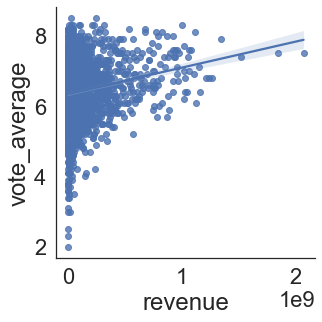

In [142]:
a1_movies = movies_final.drop_duplicates(subset=['id'])
sns.lmplot(x="revenue", y="vote_average", data=a1_movies)

### Oscar Wins Per Movie
Now we want to check the distribution of our movies, how many oscars has each movie won and the relationship between them and revenue/rating

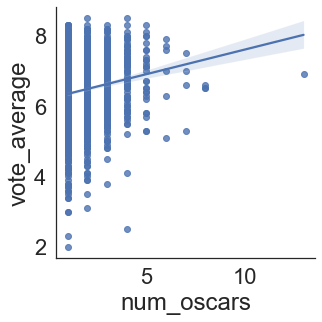

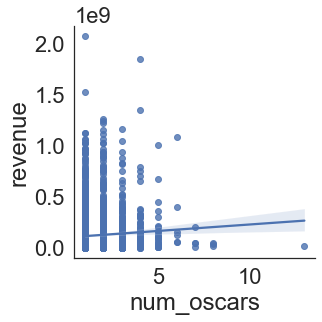

In [143]:
a2_movies = movies_final
a2_movies['movie_oscars'] = a2_movies.groupby(['id'])['id'].transform('count')
a2_movies = movies_final.drop_duplicates(subset=['id'])
sns.lmplot(x="movie_oscars", y="vote_average", data=a2_movies)
sns.lmplot(x="movie_oscars", y="revenue", data=a2_movies)

### Total Crew Oscar Count

Lastly, we want to check the relationship between entire num of oscars of all actors from all time that happened to be in this movie vs this movie's stats

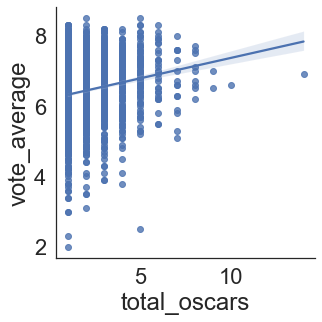

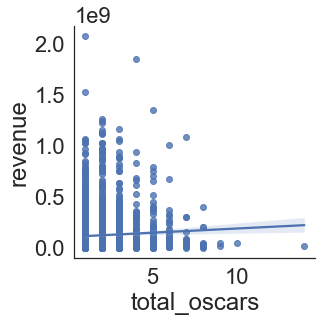

In [146]:
a3_movies = movies_final
a3_movies['actors_oscars'] = a3_movies.groupby(['id'])['win_num'].transform('sum')
a3_movies = movies_final.drop_duplicates(subset=['id'])
sns.lmplot(x="actors_oscars", y="vote_average", data=a3_movies)
sns.lmplot(x="actors_oscars", y="revenue", data=a3_movies)

# Conclusion & Discussion

In this project I chose to use three analytical points of view to analyze the overarching question of the impact that cast members having received Oscars has on their current movie’s overall success as measured by box office income and Movie Lens critics scores. When looking at the analysis regarding what it means for a movie to truly be successful, we analyzed the ratio of critic score in comparison to the box office revenue. It became clear that both are comfortably related in that a high revenue film received reasonably high reviews, and no low reviews, while low revenue films could receive both high reviews as well as low. The conclusion that can be drawn from this is that revenue does play a direct role in the movies overall success, while critic score has more room for variation. Movies that received larger amounts of revenue were guaranteed to receive higher critic scores.

When looking at the relationship between Oscar winners and success it can be seen that both the number of total Oscars that that movie received and the total number of Oscar’s won by the cast up till that point had very similar results. Both categories of Oscars for that movie versus total Oscars held by the cast were broken up to see the differences in revenue and critic score. In both cases, a stronger positive relationship was found between critic score and the number of Oscars than revenue, which makes sense since the same critics mindset is used to determine the award nominees. To my surprise oscar wins per movie versus per actor/creator did not have a significant effect on the relationship slope. You can observe the main difference in data points as you get closer to higher oscar values. To answer my initial question, there is a medium positive relationship between the total number of oscars won by the cast members and the success of the respective movies.